In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,datetime,os,time,math

import torch
import modin.pandas as pd
import seaborn as sns

from itertools import product

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split

import pickle,h5py,json

import urllib
from bs4 import BeautifulSoup
from lmfit import Model as lmmodel

sns.set()

In [2]:
rootpath = '..\\..\\TF_data\\STOCKDATA\\Data\\DJIA\\'

In [3]:
df_dj = pd.read_csv(rootpath+'DJIA\\DJIA.csv',index_col='DATE',parse_dates=['DATE'])

df_dj['DJIA'] = df_dj['DJIA'].apply(lambda x: np.nan if x=='.' else float(x))
df_dj = df_dj.resample('MS').mean()

To request implementation, send an email to feature_requests@modin.org.


In [4]:
df = pd.read_csv(rootpath+'DJIA30\\all_stocks_2006-01-01_to_2018-01-01.csv',index_col='Date',parse_dates=['Date'])

df = df[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':'0_AVG'})
df = df.resample('MS').mean()

In [5]:
date_min = max(df.index.min(),df_dj.index.min())
date_max = min(df.index.max(),df_dj.index.max())

In [6]:
df_dj = df_dj[date_min:date_max]
df = df[date_min:date_max]

In [7]:
for filename in os.listdir(rootpath+'DJIA30\\'):
    if filename.split('_')[0]=='all': continue
    cf = pd.read_csv(rootpath+'DJIA30\\'+filename,index_col='Date',parse_dates=['Date'])
    cf = cf[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':filename.split('_')[0]})
    df[filename.split('_')[0]] = cf.resample('MS').mean()[date_min:date_max]

In [8]:
df['0_DJIA'] = df_dj

In [9]:
df = df[df.columns.sort_values()]

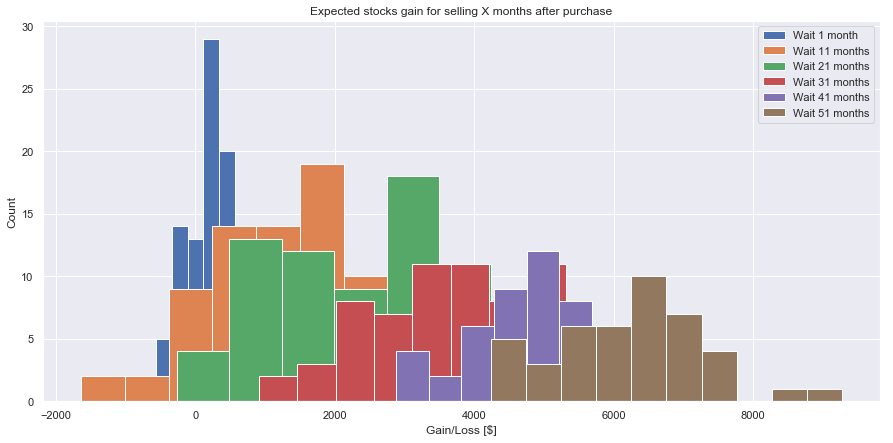

In [10]:
ax = plt.figure(figsize=(15,7))
ax = df['0_DJIA'].diff(periods=1).hist(label='Wait 1 month')

for k in range(11,61,10):
    df['0_DJIA'].diff(periods=k).hist(ax=ax,label='Wait '+str(k)+' months')
ax.legend()
    
plt.title('Expected stocks gain for selling X months after purchase')
plt.ylabel('Count')
plt.xlabel('Gain/Loss [$]')
plt.show()

In [11]:
dfX = df.copy().drop(columns=['0_DJIA','0_AVG'])

In [12]:
dfY = pd.DataFrame(index=df.index)

In [13]:
for colname in dfX.columns.tolist():
    tf = df[['0_AVG',colname]].diff(periods=3)
    tf['delta'] = tf[['0_AVG',colname]].apply(lambda x: 0 if x[1]-x[0]<0 or np.isnan(x[0]) or np.isnan(x[1]) else 1,axis=1)
    dfY[colname] = tf['delta']

In [14]:
dfY.iloc[:3] = np.nan

In [15]:
dfX

,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-01,16.256087,31.829130,130.302609,40.228261,69.560870,60.061739,25.866087,74.144348,33.505652,17.319130,...,29.253478,17.750435,17.346957,63.606087,53.570435,33.278261,71.970870,30.019565,54.871739,66.644783
2010-04-01,17.462500,35.955500,141.152000,45.053810,72.578095,67.109524,26.854500,80.063333,36.076190,18.869048,...,30.493000,18.920476,16.915714,62.990952,52.503810,31.622857,74.648571,29.870476,54.627619,68.348095
2010-05-01,15.965000,35.999000,127.790500,41.803000,68.259500,63.628500,24.966500,77.150500,34.259000,17.413500,...,28.282500,18.465000,16.175500,61.845500,49.655000,29.575000,70.548500,28.254000,52.360000,63.397000
2010-06-01,15.136364,37.483636,122.325000,40.674091,65.195909,61.824091,22.935455,72.945455,34.001818,15.654091,...,25.585455,17.945909,14.984545,61.177273,50.191364,30.345455,66.862727,28.411818,50.783636,60.995000
2010-07-01,14.435714,36.497619,116.489048,42.489524,64.821429,65.325238,22.767619,72.058571,33.344762,15.082381,...,25.033333,17.596667,14.732381,61.484286,50.020952,30.121905,67.808571,27.303810,50.015714,58.919048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,61.336522,158.946957,973.247826,85.610435,237.822609,114.368261,31.462174,108.443913,103.610870,25.039565,...,72.715652,56.907391,33.248696,91.865652,127.712174,194.213913,117.491739,48.375217,80.029565,78.124783
2017-09-01,65.530000,158.109000,971.953000,87.211000,247.099500,121.674500,32.521000,114.133000,99.050500,24.411500,...,74.365500,53.095500,35.042000,92.861500,120.877500,196.945500,113.266500,48.102000,79.505500,79.637500
2017-10-01,67.611364,157.355909,999.540000,92.376818,259.348636,131.002273,33.839545,117.991818,98.850000,22.974545,...,77.893182,52.625000,36.053182,90.501364,128.326818,201.282273,118.839091,48.959091,84.505000,82.579545


In [16]:
dfY

,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-01,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2010-07-01,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2017-09-01,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-10-01,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [17]:
lookback = 15

In [18]:
X = []
y = []

In [19]:
for colname in dfX.columns.tolist():
    for k in range(lookback,dfX.shape[0]):
        X.append(np.array([dfX[colname].values[k-lookback:k],df['0_DJIA'].values[k-lookback:k],df['0_AVG'].values[k-lookback:k]]))
        y.append(dfY[colname].values[k])

In [20]:
X = np.stack(X,axis=0)
y = np.stack(y,axis=0).reshape(-1,1)

In [21]:
X0,X1,y0,y1 = train_test_split(X,y,test_size=0.2,shuffle=True)

In [ ]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self):
        super(LSTMClassifier,self).__init__()
        self.output_size = 